In [50]:
import numpy as np 
import pandas as pd 
import re
import catboost
import warnings
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [51]:
df = pd.read_csv(r"C:\Users\abood\Downloads\widsdatathon2024-challenge1\training.csv")

In [52]:
df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,NaN,NaN,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,NaN,NaN,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,NaN,NaN,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.62

<AxesSubplot:>

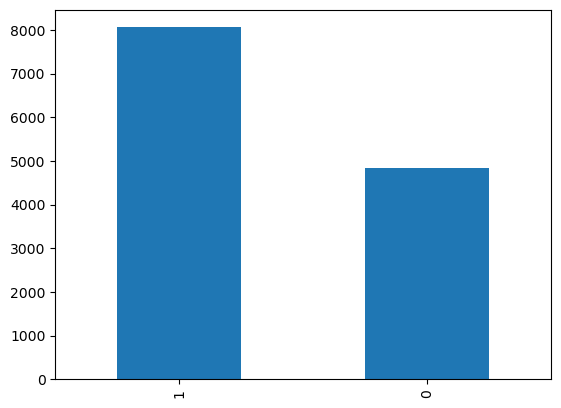

In [53]:
df['DiagPeriodL90D'].value_counts().plot(kind = 'bar')

In [54]:
# Number of null values in each column 
df.isna().sum()

patient_id                                   0
patient_race                              6385
payer_type                                1803
patient_state                               51
patient_zip3                                 0
patient_age                                  0
patient_gender                               0
bmi                                       8965
breast_cancer_diagnosis_code                 0
breast_cancer_diagnosis_desc                 0
metastatic_cancer_diagnosis_code             0
metastatic_first_novel_treatment         12882
metastatic_first_novel_treatment_type    12882
Region                                      52
Division                                    52
population                                   1
density                                      1
age_median                                   1
age_under_10                                 1
age_10_to_19                                 1
age_20s                                      1
age_30s      

In [56]:
# Fill nulls in Ozone,PM25,N02 according to the zip

x =['Ozone','PM25','N02','patient_state']
for i in x :
    df[i] = df[i].astype(str)
    area_mode_mapping = df.groupby('patient_zip3')[i].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()
    df[i] = df.apply(lambda row: area_mode_mapping[row['patient_zip3']] if pd.isnull(row[i]) else row[i], axis=1)

    


In [57]:
x = ['patient_race','payer_type','patient_state','patient_zip3','patient_gender','bmi','breast_cancer_diagnosis_code',
     'breast_cancer_diagnosis_desc','metastatic_cancer_diagnosis_code']
df_bmi = df[x]
categorical_cols = df_bmi.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if col != 'DiagPeriodL90D':
        mode = df[col].mode()[0]
        df_bmi[col].fillna(mode, inplace=True)
        
from sklearn.preprocessing import OneHotEncoder 
label_encoder = OneHotEncoder(handle_unknown='ignore')

for c in categorical_cols:
  label_encoder.fit(df_bmi[[c]])
  df_bmi[label_encoder.categories_[0]]= label_encoder.transform(df_bmi[[c]]).toarray()
  df_bmi.drop(columns=[c],inplace=True)

        
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3, weights='uniform')
imputed_data = knn_imputer.fit_transform(df_bmi)

imputed_df = pd.DataFrame(imputed_data, columns=df_bmi.columns)

df['bmi'] = imputed_df['bmi']



In [8]:
# Create a new column called bmi_class

bmi_thresholds = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
bmi_labels = ['Underweight', 'Normal Weight', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III']

# Create a new column 'bmi_class' based on BMI thresholds
df['bmi_class'] = pd.cut(df['bmi'], bins=bmi_thresholds, labels=bmi_labels, right=False)


In [9]:
# Extract the tumor region from the diagnosis description 

region_pattern = re.compile(r'(?<=m of )\S+')
df['tumor_region'] = df['breast_cancer_diagnosis_desc'].apply(lambda x: region_pattern.search(x).group() if region_pattern.search(x) else None)
df['tumor_region'] = df['tumor_region'].replace({'unsp': 'unspecified', 'ovrlp': 'overlapping', 'nipple': 'central', 'breast': 'unspecified'})


In [10]:
#Include the essential columns while ignoring any unnecessary ones

x = ['breast_cancer_diagnosis_code', 'patient_age', 'metastatic_cancer_diagnosis_code', 'tumor_region', 'rent_burden',
     'income_household_75_to_100', 'patient_race', 'payer_type', 'unemployment_rate', 'income_household_under_5', 
     'self_employed', 'age_10_to_19', 'PM25', 'patient_state', 'age_50s', 'race_native', 'race_multiple', 'commute_time',
     'patient_zip3', 'family_size','bmi_class','DiagPeriodL90D']

df = df[x]


In [11]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns


In [12]:

# Impute categorical columns using mode
for col in categorical_cols:
    if col != 'DiagPeriodL90D':
        mode = df[col].mode()[0]
        df[col].fillna(mode, inplace=True)

# # Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        m = df[col].median()
        df[col].fillna(m, inplace=True)


In [13]:
# Convert the Categorical columns to numeric 
from sklearn.preprocessing import OneHotEncoder 
label_encoder = OneHotEncoder(handle_unknown='ignore')

for c in categorical_cols:
    label_encoder.fit(df[[c]])
    df[label_encoder.categories_[0]]= label_encoder.transform(df[[c]]).toarray()
    df.drop(columns=[c],inplace=True)
    

In [14]:
X  = df.drop('DiagPeriodL90D', axis=1)  
y = df['DiagPeriodL90D'] 
 

In [15]:
y.value_counts()

1    8060
0    4846
Name: DiagPeriodL90D, dtype: int64

In [16]:
# using oversampling technique to handle class imbalance
# The 'sampling_strategy' parameter determines the ratio of synthetic samples for the minority class
smote = SMOTE(sampling_strategy=0.7)  
X_new, y_new = smote.fit_resample(X, y)

In [17]:
X_new.shape

(13702, 180)

<AxesSubplot:>

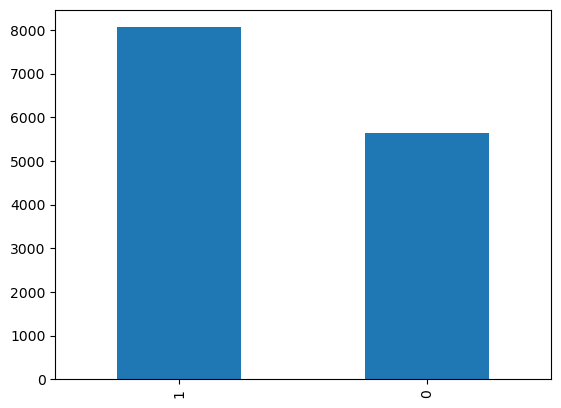

In [18]:
y_new.value_counts().plot(kind = 'bar')

In [19]:
#### Optimizing CatBoost Classifier Parameters with Grid Search for Improved Model Performance on Classification Tasks
                                            # in Machine Learning."


# CBC = CatBoostClassifier()

# parameters = {    'learning_rate' : [0.03,0.06,0.09,0.11,0.13],
#                   'iterations'    : [500,1000 , 2000, 3000, 4000]}
# Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
# Grid_CBC.fit(X, y)
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new ,test_size=0.2, random_state=42)

model1 = CatBoostClassifier(iterations=500, learning_rate=0.03 , verbose = 250)

model1.fit(X_train ,  y_train)
y_pred = model1.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)

print(f"ROC-AUC Score for Training Data: {roc_auc}")

0:	learn: 0.6799093	total: 163ms	remaining: 1m 21s
250:	learn: 0.4283877	total: 4.99s	remaining: 4.95s
499:	learn: 0.3915094	total: 9.21s	remaining: 0us
ROC-AUC Score for Training Data: 0.8251423877990749


In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation and get the accuracy scores
cross_val_scores = cross_val_score(model1, X_new, y_new, cv=kf, scoring='roc_auc')

0:	learn: 0.6799185	total: 16.6ms	remaining: 8.26s
250:	learn: 0.4272727	total: 4.24s	remaining: 4.21s
499:	learn: 0.3921222	total: 8.99s	remaining: 0us
0:	learn: 0.6790137	total: 21ms	remaining: 10.5s
250:	learn: 0.4276419	total: 6.03s	remaining: 5.98s
499:	learn: 0.3936751	total: 10.5s	remaining: 0us
0:	learn: 0.6798675	total: 15.6ms	remaining: 7.77s
250:	learn: 0.4335436	total: 4.15s	remaining: 4.12s
499:	learn: 0.3978169	total: 7.97s	remaining: 0us
0:	learn: 0.6800166	total: 16.5ms	remaining: 8.23s
250:	learn: 0.4307695	total: 3.85s	remaining: 3.82s
499:	learn: 0.3958821	total: 7.94s	remaining: 0us
0:	learn: 0.6793392	total: 17.5ms	remaining: 8.71s
250:	learn: 0.4306538	total: 3.65s	remaining: 3.62s
499:	learn: 0.3955486	total: 7.75s	remaining: 0us


In [22]:
# Mean Cross-Validation Score for Model Evaluation in Machine Learning with CatBoost Classifier
print(f'Mean Cross-Validation ROC-AUC Score : {cross_val_scores.mean()}')

Mean Cross-Validation ROC-AUC Score : 0.8336771379748287
